# ResNet Multiphase Pipeline: Preprocessing and Training

Approach:
- Load in samples
- Create MIPs from the top of the head (note that these images are already pre-MIPed, but we may want thicker slices
- Reshape images
- Feed into Resnet model
- Train

## Imports

In [1]:
import os
import pathlib
import typing
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

## Load Data

Load in some sample scans. Here we take out 20 positive scans.

In [2]:
# data_dict = load_data('/home/elvo-analysis/data/numpy/')
dir_path = '/research/rih-cs/datasets/elvo-multiphase/v0.1/positive'

In [3]:
samples = []  # list of list, where each inner list rep's one pa
sample_size = 20  # here for trial and error. to be removed later
i = 1
for npz_file in os.listdir(dir_path):
    if i > sample_size:
        break
    i += 1
    one_patient = []
    if npz_file.endswith(".npz"):  # ignore gstmp files
        npy_files = np.load(dir_path + '/' + npz_file)
        for file in npy_files:
            one_patient.append(npy_files[file])
    samples.append(one_patient)

## Data Exploration

Check that we have the correct number of scans in our sample. Expected: 20 x 3 = 60 3D numpy arrays in total

In [4]:
print(len(samples) == sample_size)  # expected True

True


Check the shape of each of these arrays. One key part of this preprocessing pipeline is to make every scan the same shape.

In [5]:
# expected: a number of patients specified by sample_size, each with 2 scans
for i, patient in enumerate(samples):
    print("patient {}".format(i))
    for scan in patient:
        print(scan.shape)

patient 0
(1512, 230, 230)
(1344, 221, 178)
(1080, 222, 174)
patient 1
(1896, 230, 230)
(1008, 199, 168)
(1056, 193, 168)
patient 2
(1416, 230, 230)
(864, 176, 174)
(864, 176, 162)
patient 3
(1320, 230, 230)
(1080, 203, 160)
(1080, 203, 172)
patient 4
(1944, 230, 230)
(1152, 224, 193)
(1176, 225, 193)
patient 5
(1416, 230, 230)
(888, 216, 211)
(960, 206, 201)
patient 6
(1656, 230, 230)
(936, 197, 182)
(984, 197, 180)
patient 7
(1920, 230, 230)
(960, 200, 154)
(984, 199, 150)
patient 8
(1464, 230, 230)
(984, 186, 158)
(1032, 184, 160)
patient 9
(1560, 230, 230)
(1104, 203, 180)
(1128, 203, 182)
patient 10
(1560, 230, 230)
(1152, 181, 148)
(1176, 181, 148)
patient 11
(1416, 230, 230)
(936, 197, 174)
(936, 199, 174)
patient 12
(1656, 230, 230)
(1128, 229, 185)
(1200, 229, 188)
patient 13
(1512, 230, 230)
(864, 195, 164)
(936, 195, 166)
patient 14
(1824, 230, 230)
(1104, 203, 181)
(1056, 205, 181)
patient 15
(1728, 230, 230)
(1272, 215, 201)
(1248, 215, 203)
patient 16
(1536, 230, 230)
(96

## Create MIPs

We create mips of each phase of each patient's scans. This means there are totals of EITHER:
- 3 mips (single channel mips), corresponding to 3 different phases OR
- 9 mips (multichannel mips), corresponding to 3 mips for each phase

NOTE: We need to tweak this step so we start counting the slices from the TOP of the head, which is originally the greatest index in the array's z-dim.

In [6]:
def mip(arr: np.ndarray, start: int, thickness: int) -> np.ndarray:
    "return one MIP given a 3D array and a start index"
    mip = np.copy(arr)
    mip = mip[-start - thickness:-start]
    return np.amax(mip, axis=0)

def multichan_mip(arr: np.ndarray, start: int, thickness: int) -> np.ndarray:
    "return three MIPS given a 3D array and start index, counted from the TOP of the head"
    start_1 = start + thickness
    start_2 = start_1 + thickness
    
    return mip(arr, start, thickness), mip(arr, start_1, thickness), mip(arr, start_2, thickness)

### Testing Single Channel MIPs

In [7]:
mipped_1 = []  # lists of lists, packaging the different phases together
mipped_2 = []
mipped_3 = []

for s in samples:
    assert len(s) == 3
    m_1 = mip(s[0], 500, 50)
    m_2 = mip(s[1], 500, 50)
    m_3 = mip(s[2], 500, 50)
    mipped_1.append(m_1)
    mipped_2.append(m_2)
    mipped_3.append(m_3)

    
print(len(mipped_1))
print(len(mipped_2))
print(len(mipped_3))

20
20
20


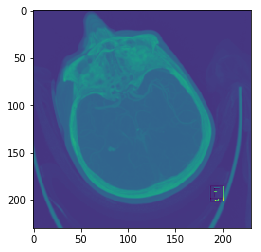

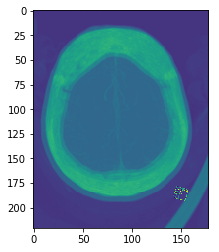

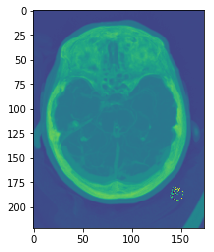

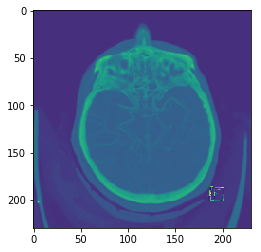

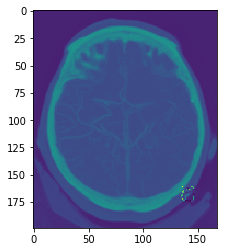

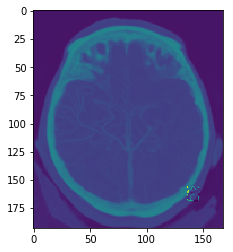

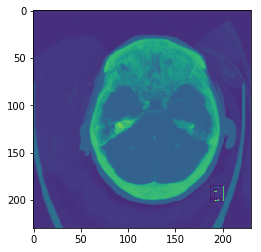

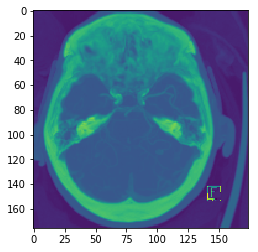

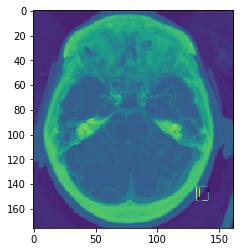

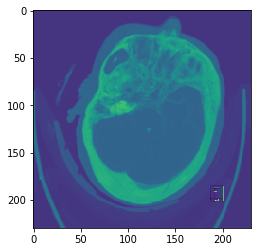

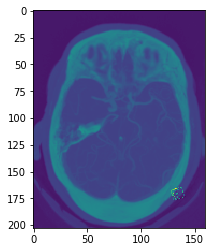

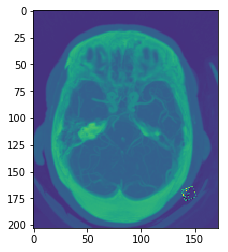

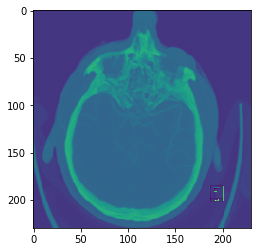

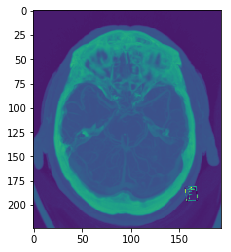

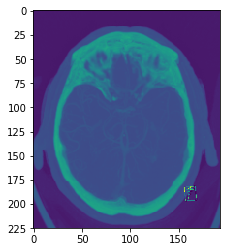

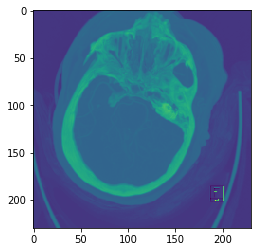

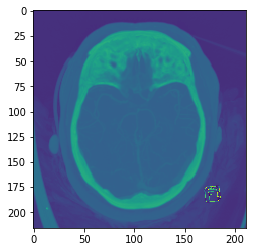

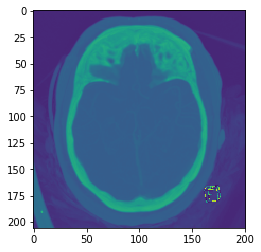

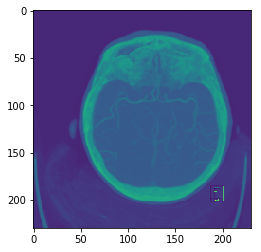

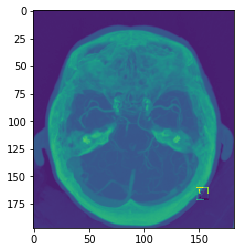

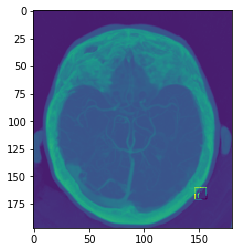

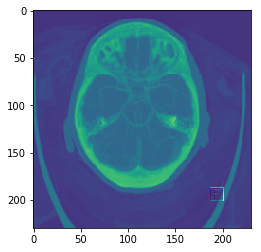

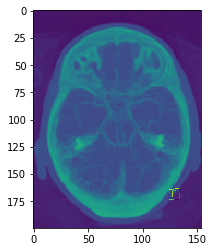

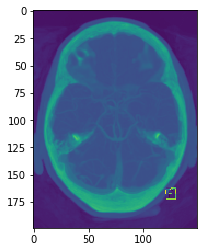

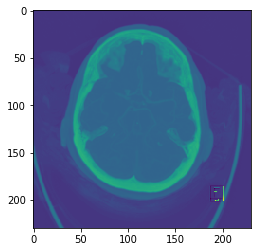

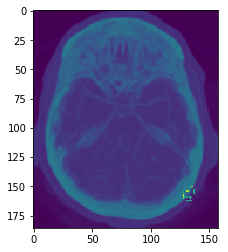

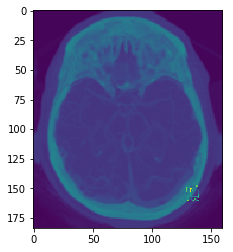

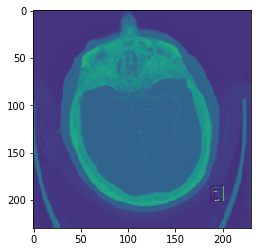

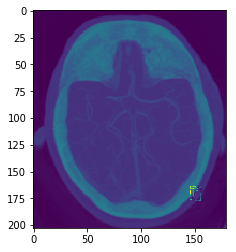

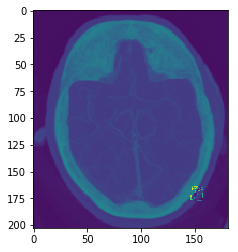

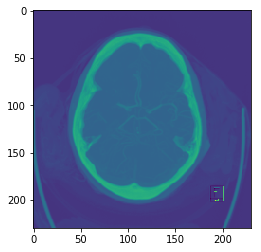

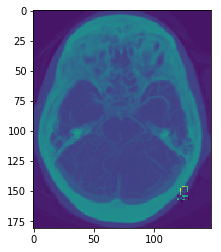

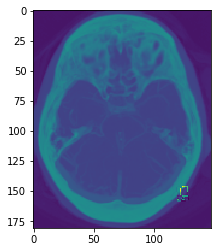

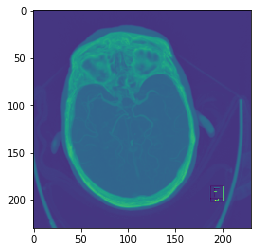

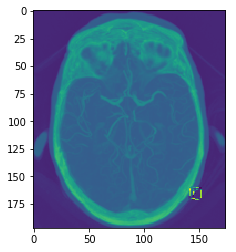

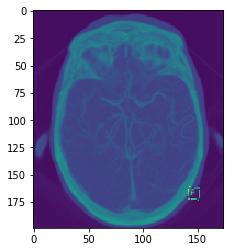

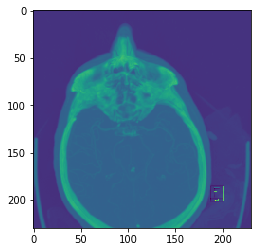

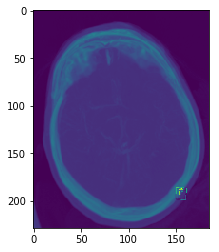

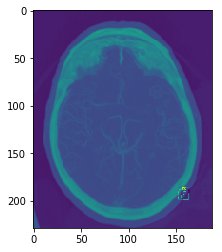

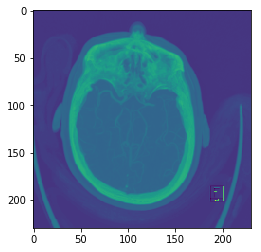

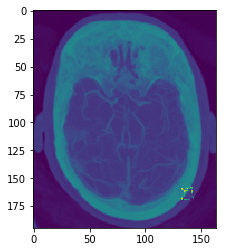

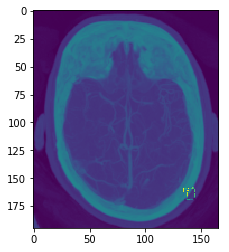

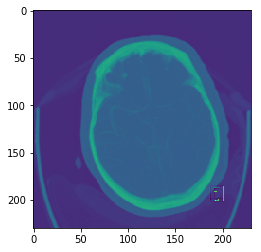

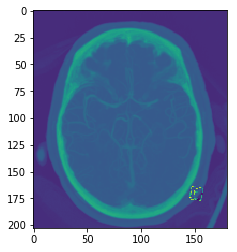

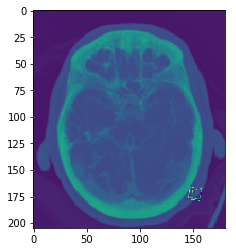

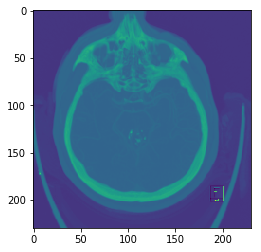

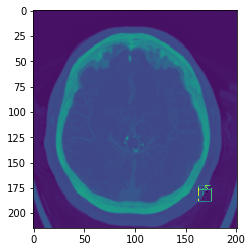

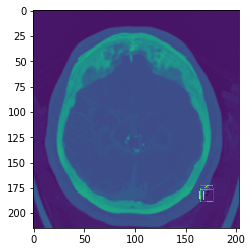

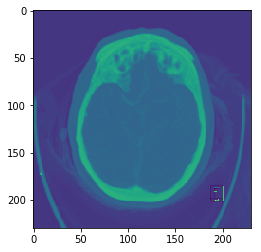

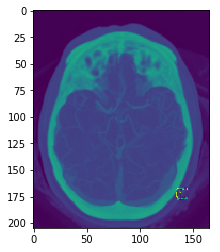

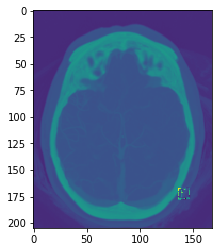

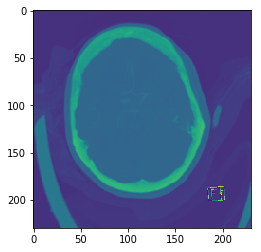

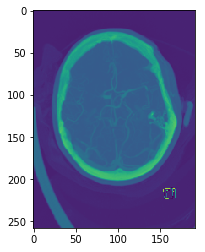

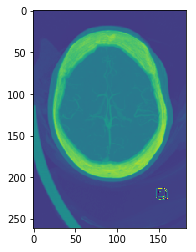

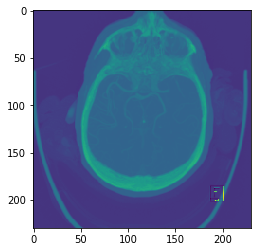

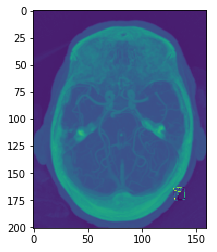

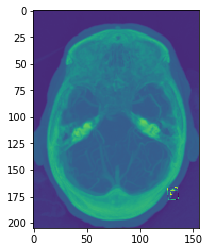

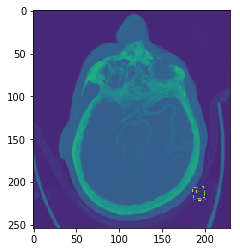

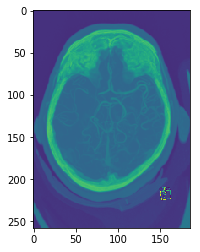

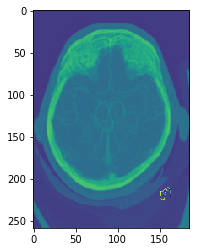

In [8]:
for i in range(20):
    plt.imshow(mipped_1[i])
    plt.show();
    plt.imshow(mipped_2[i])
    plt.show();
    plt.imshow(mipped_3[i])
    plt.show();

### TODO: Testing Multi Channel MIPs

## Resize Images

Make all images the same shape after MIPing

In [9]:
import math

def center_resize(arr: np.ndarray, size: tuple) -> np.ndarray:
    """
    crops a numpy array from the center, with equal spacing on edges
    if desired size is greater than array size, pad arrays with zeros
    specifically for 2d scans where only the x- and y-axes need reshaping AFTER miping
    """
    arr_size = arr.shape
    assert len(arr_size) == 2  # func intended for only 2d arrays
    assert len(size) == 2
    
    x_val = arr_size[0]
    y_val = arr_size[1]
    x_target = size[0]
    y_target = size[1]
    
    # pad with zeros if needed
    new_arr = np.copy(arr)
    if x_val < x_target:  # pad x
        diff = (x_target - x_val)
        x_pad = math.ceil(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = np.pad(arr, ((x_pad, x_pad), (0, 0)), 'constant', constant_values=(0, 0))
        else:
            new_arr = np.pad(arr, ((x_pad-1, x_pad), (0, 0)), 'constant', constant_values=(0, 0))
    if y_val < y_target:  # pad y
        diff = y_target - y_val
        y_pad = math.ceil(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = np.pad(new_arr, ((0, 0), (y_pad, y_pad)), 'constant', constant_values=(0, 0))
        else:
            new_arr = np.pad(new_arr, ((0, 0), (y_pad-1, y_pad)), 'constant', constant_values=(0, 0))
    
    # crop equally from both sides
    if x_val > x_target:  # crop x
        diff = x_val - x_target
        x_crop = math.floor(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = new_arr[x_crop:x_val-x_crop]
        else:
            new_arr = new_arr[x_crop + 1:x_val-x_crop]
    if y_val > y_target:  # crop x
        diff = y_val - y_target
        y_crop = math.floor(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = [arr[y_crop:y_val-y_crop] for arr in new_arr]
        else:
            new_arr = [arr[y_crop + 1:y_val-y_crop] for arr in new_arr]
    
    return np.array(new_arr)
    

### Testing Resizing

In [10]:
reshaped_mipped_1 = []
reshaped_mipped_2 = []
reshaped_mipped_3 = []

for i in range(sample_size):
    r_1 = center_resize(mipped_1[i], (200, 200))
    r_2 = center_resize(mipped_2[i], (200, 200))
    r_3 = center_resize(mipped_3[i], (200, 200))

    reshaped_mipped_1.append(r_1)
    reshaped_mipped_2.append(r_2)
    reshaped_mipped_3.append(r_3)

    
print(len(reshaped_mipped_1))
print(len(reshaped_mipped_2))
print(len(reshaped_mipped_3))

20
20
20


In [11]:
# for i in range(20):
#     print(reshaped_mipped_1[i].shape)
#     print(reshaped_mipped_2[i].shape)
#     print(reshaped_mipped_3[i].shape)

patient 0, phase 1


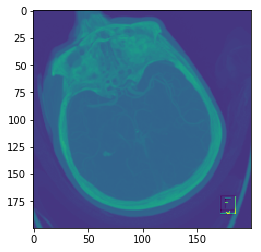

patient 0, phase 2


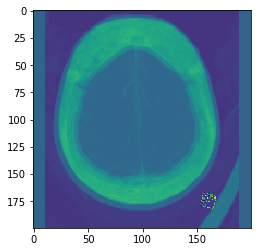

patient 0, phase 3


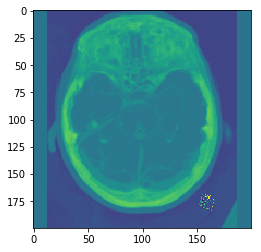

patient 1, phase 1


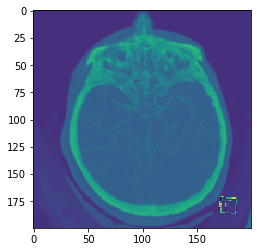

patient 1, phase 2


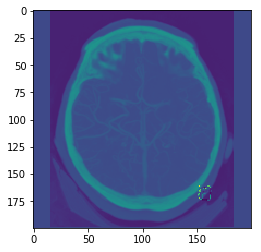

patient 1, phase 3


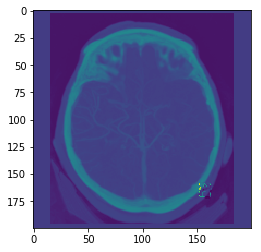

patient 2, phase 1


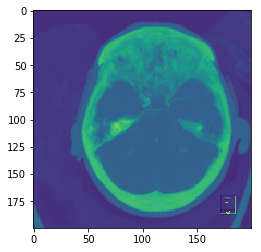

patient 2, phase 2


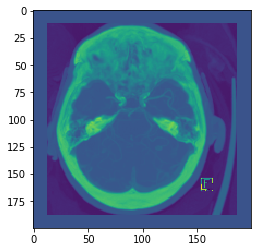

patient 2, phase 3


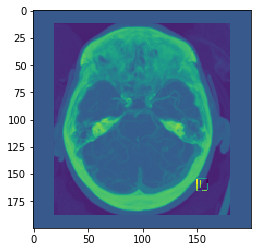

patient 3, phase 1


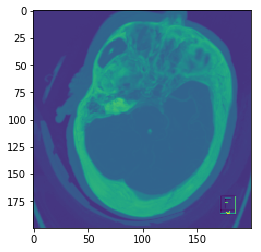

patient 3, phase 2


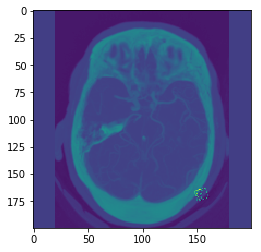

patient 3, phase 3


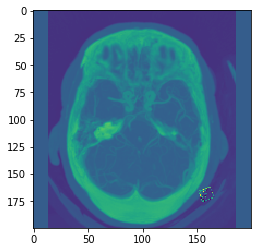

patient 4, phase 1


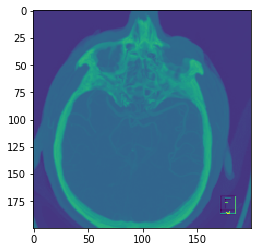

patient 4, phase 2


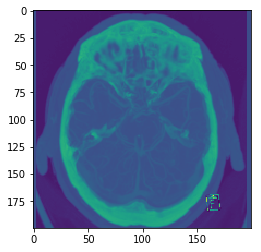

patient 4, phase 3


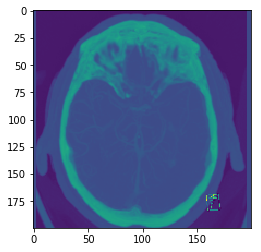

patient 5, phase 1


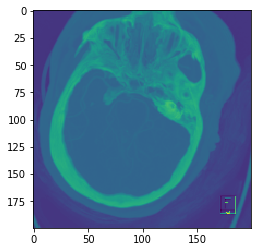

patient 5, phase 2


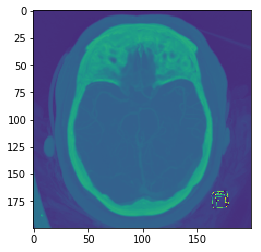

patient 5, phase 3


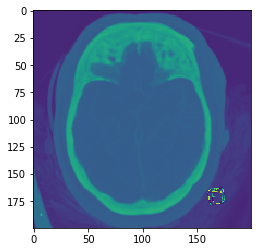

patient 6, phase 1


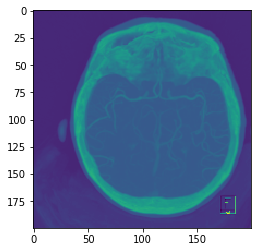

patient 6, phase 2


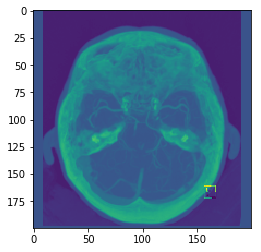

patient 6, phase 3


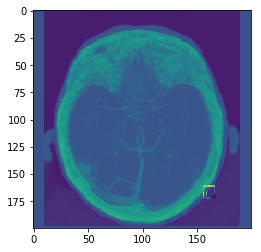

patient 7, phase 1


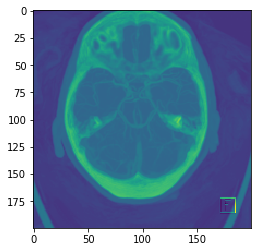

patient 7, phase 2


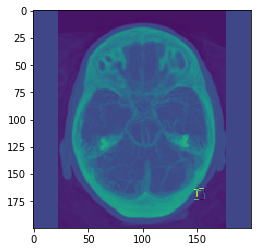

patient 7, phase 3


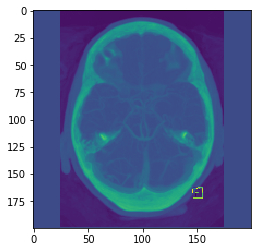

patient 8, phase 1


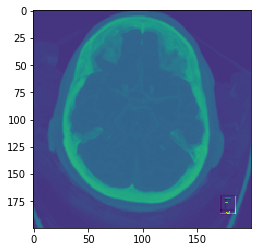

patient 8, phase 2


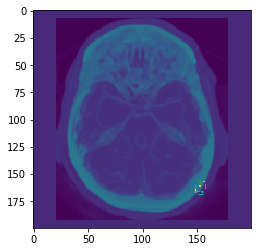

patient 8, phase 3


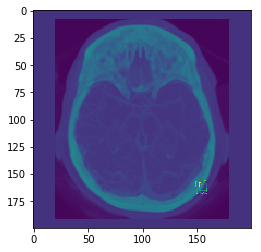

patient 9, phase 1


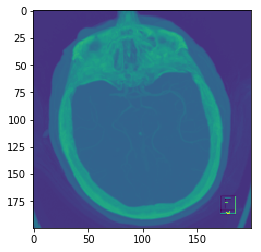

patient 9, phase 2


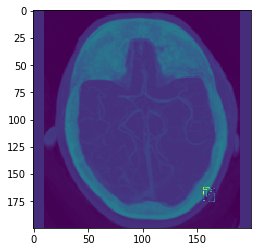

patient 9, phase 3


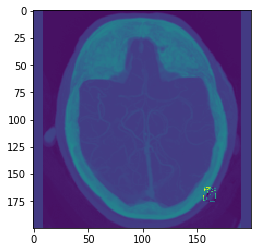

patient 10, phase 1


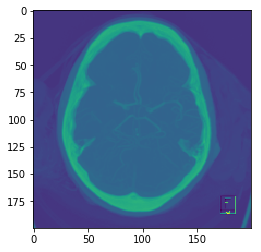

patient 10, phase 2


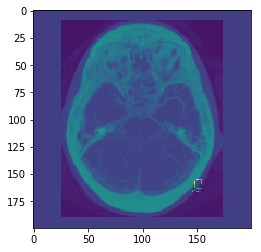

patient 10, phase 3


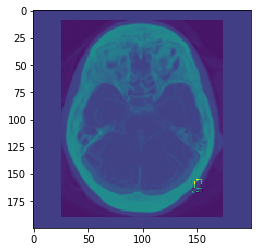

patient 11, phase 1


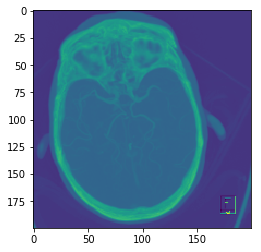

patient 11, phase 2


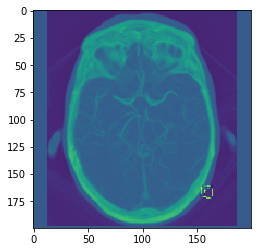

patient 11, phase 3


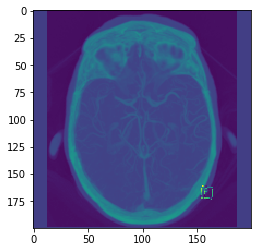

patient 12, phase 1


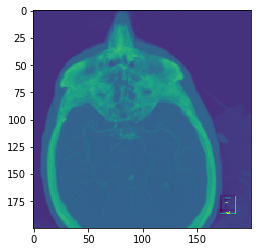

patient 12, phase 2


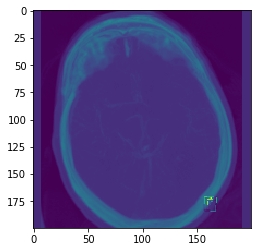

patient 12, phase 3


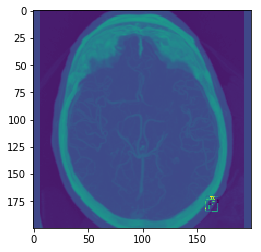

patient 13, phase 1


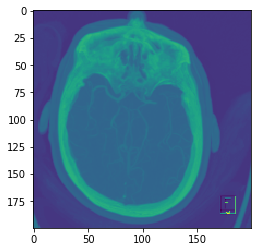

patient 13, phase 2


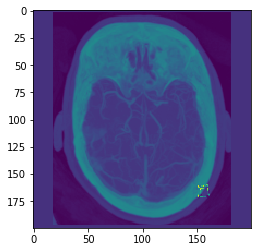

patient 13, phase 3


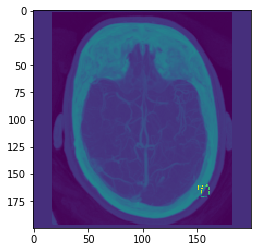

patient 14, phase 1


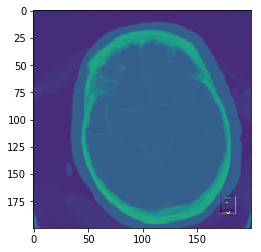

patient 14, phase 2


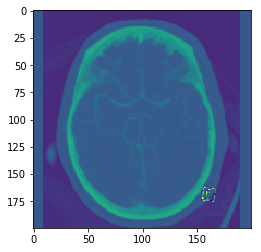

patient 14, phase 3


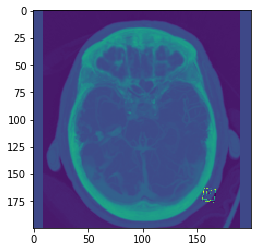

patient 15, phase 1


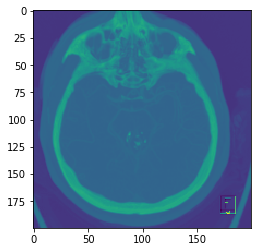

patient 15, phase 2


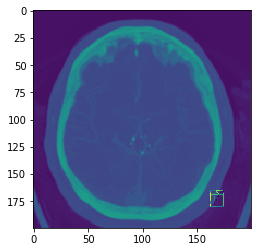

patient 15, phase 3


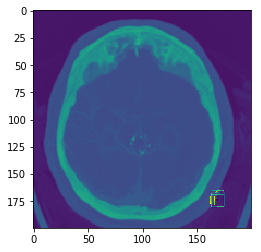

patient 16, phase 1


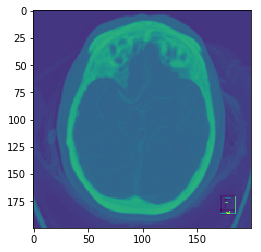

patient 16, phase 2


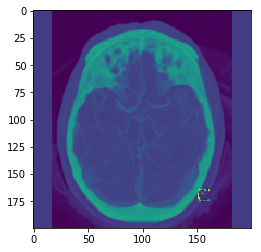

patient 16, phase 3


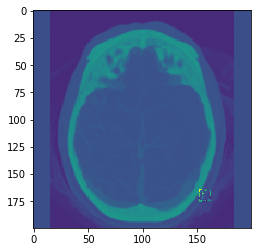

patient 17, phase 1


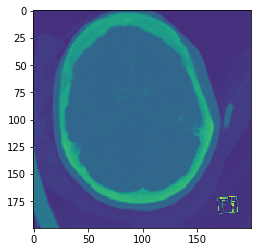

patient 17, phase 2


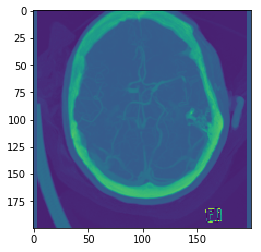

patient 17, phase 3


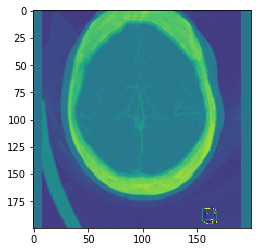

patient 18, phase 1


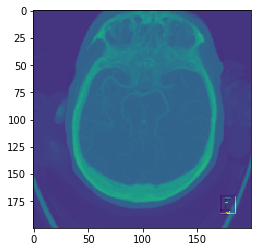

patient 18, phase 2


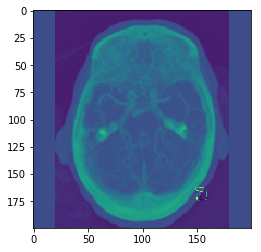

patient 18, phase 3


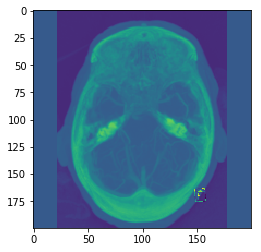

patient 19, phase 1


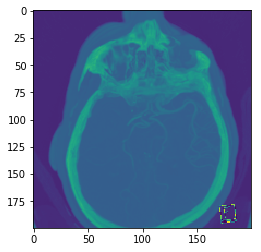

patient 19, phase 2


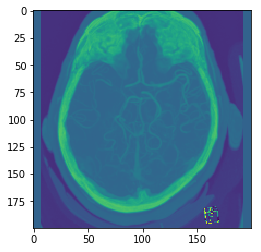

patient 19, phase 3


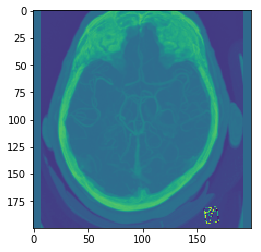

In [12]:
for i in range(20):
    print("patient {}, phase 1".format(i))
    plt.imshow(reshaped_mipped_1[i])
    plt.show();
    
    print("patient {}, phase 2".format(i))
    plt.imshow(reshaped_mipped_2[i])
    plt.show();
    
    print("patient {}, phase 3".format(i))
    plt.imshow(reshaped_mipped_3[i])
    plt.show();

## Training: Load in all data
We will iterate through the pos and neg directory of phase1 to get the index of our train/test/val set. 


In [13]:
TRAIN_DATA = ['P25', 'P48', 'P62', 'P72', 'P144', 'P149', 'P1', 'P4', 'P16', 'P21', 'P32', \
'P36', 'P38', 'P52', 'P59', 'P88', 'P89', 'P118', 'P164', 'P232', 'P255', 'P266', 'P280', \
'P289', 'P73', 'P78', 'P120', 'P142', 'P126', 'P145', 'P147', 'P3', 'P5', 'P6', 'P15', \
'P17', 'P22', 'P28', 'P29', 'P34', 'P57', 'P58', 'P61', 'P66', 'P68', 'P70', 'P77', 'P80', \
'P85', 'P87', 'P94', 'P102', 'P106', 'P107', 'P110', 'P125', 'P127', 'P130', 'P134', 'P135', \
'P141', 'P150', 'P152', 'P153', 'P158', 'P163', 'P166', 'P179', 'P180', 'P181', 'P182', 'P185', \
'P207', 'P209', 'P210', 'P216', 'P218', 'P222', 'P224', 'P225', 'P231', 'P8', 'P13', 'P18', \
'P24', 'P33', 'P40', 'P43', 'P44', 'P47', 'P51', 'P53', 'P56', 'P63', 'P67', 'P69', 'P81', \
'P100', 'P101', 'P111', 'P117', 'P124', 'P146', 'P168', 'P184', 'P187', 'P188', 'P208', 'P212', \
'P248', 'P112', 'P2', 'P10', 'P20', 'P26', 'P46', 'P60', 'P79', 'P93', 'P95', 'P98', 'P116', 'P121', \
'P136', 'P143', 'P148', 'P160', 'P189', 'P203', 'P71', 'P97', 'P140', 'P84', 'P92', 'P131', 'P7', \
'P42', 'P129', 'P137', 'P154', 'P159', 'P176', 'P201', 'P213', 'P9', 'P11', 'P12', 'P19', 'P23', \
'P27', 'P30', 'P31', 'P35', 'P39', 'P45', 'P54', 'P55', 'P64', 'P65', 'P74', 'P91', 'P96', 'P99', \
'P104', 'P105', 'P108', 'P109', 'P113', 'P114', 'P119', 'P122', 'P123', 'P128', 'P132', 'P133', 'P139', \
'P151', 'P155', 'P156', 'P157', 'P165', 'P169', 'P173', 'P174', 'P177', 'P183', 'P186', 'P190', 'P192', \
'P193', 'P194', 'P197', 'P199', 'P200', 'P202', 'P205', 'P14', 'P41', 'P49', 'P75', 'P83', 'P86', 'P90', \
'P103', 'P167', 'P171', 'P196', 'P198', 'P204', 'P214', 'P254', 'P191'] 

TEST_DATA = ['P252', 'P265', 'P162', 'P170', 'P172', 'P178', 'P195', 'P221', 'P253', 'P234', 'P236', 'P237', \
'P241', 'P262', 'P272', 'P277', 'P282', 'P284', 'P285', 'P288', 'P291', 'P293', 'P296', 'P220', 'P228', \
'P246', 'P250', 'P270', 'P273', 'P283', 'P302', 'P268', 'P292', 'P226', 'P245', 'P263', 'P269', 'P286', \
'P217', 'P219', 'P233', 'P244', 'P206', 'P211', 'P215', 'P223', 'P227', 'P235', 'P243', 'P257', 'P258', \
'P260', 'P261', 'P267', 'P275', 'P278', 'P264', 'P274', 'P276', 'P279', 'P242']

VAL_DATA = ['P271', 'P259', 'P238', 'P281', 'P229', 'P240', 'P297', 'P309', 'P310', 'P50', 'P76', 'P230', \
'P304', 'P305', 'P306', 'P307', 'P308', 'P300', 'P290', 'P298', 'P299', 'P249', 'P239', 'P294', 'P301', \
'P303', 'P161', 'P256', 'P37', 'P287', 'P295', 'P82', 'P247'] 

In [86]:
# data_dict = load_data('/home/elvo-analysis/data/numpy/')
pos_dir_path = '/research/rih-cs/datasets/elvo-multiphase/v0.1/positive'
neg_dir_path = '/research/rih-cs/datasets/elvo-multiphase/v0.1/negative'

In [89]:
TRAIN_INDICES = []
TEST_INDICES = []
VAL_INDICES = []

# Usage: np.stack(train_arrays)
train_arrays = []
test_arrays = []
val_arrays = []

# for i, npz_file in enumerate(sorted(os.listdir(pos_dir_path))):
#     one_patient = []
#     if npz_file.endswith(".npz"):  # ignore gstmp files
#         npy_files = np.load(pos_dir_path + '/' + npz_file)
#         for file in npy_files:
#             one_patient.append(npy_files[file])

#         matching_name = os.path.splitext(npz_file)[0] 
#         if matching_name in TRAIN_DATA:
#             train_arrays.append(one_patient)
#             TRAIN_INDICES.append(i)
#         elif matching_name in TEST_DATA: 
#             test_arrays.append(one_patient)
#             TEST_INDICES.append(i)
#         elif matching_name in VAL_DATA: 
#             val_arrays.append(one_patient)
#             VAL_INDICES.append(i)
#         else: 
#             print('file {filename}, {matching_name} is not found.'.format(
#                 filename=npz_file, matching_name=matching_name))

for i, npz_file in enumerate(sorted(os.listdir(neg_dir_path))):
    one_patient = []
    if npz_file.endswith(".npz"):  # ignore gstmp files
        npy_files = np.load(neg_dir_path + '/' + npz_file)
        for file in npy_files:
            one_patient.append(npy_files[file])

        matching_name = os.path.splitext(npz_file)[0] 
        if 0 <= i and i <= 66:
            train_arrays.append(one_patient)
            TRAIN_INDICES.append(i)
        elif 67 <= i and i <= 86:
            test_arrays.append(one_patient)
            TEST_INDICES.append(i)
        elif 87 <= i and i <= 95:
            val_arrays.append(one_patient)
            VAL_INDICES.append(i)
        else: 
            print('file {filename}, {matching_name} is not found.'.format(
                filename=npz_file, matching_name=matching_name))

### Method 1: Using the three single-channel MIPs as the three input channels
Script below saves preprocessed train, test, and val data into `/research/rih-cs/datasets/elvo-multiphase/preprocessed-2` for generator use. Each final preprocessed array should have shape (?, 3, 224, 224)

In [90]:
mipped_1 = []  # lists of lists, packaging the different phases together
mipped_2 = []
mipped_3 = []

for s in train_arrays:
    assert len(s) == 3
    m_1 = mip(s[0], 500, 50)
    m_2 = mip(s[1], 500, 50)
    m_3 = mip(s[2], 500, 50)
    mipped_1.append(m_1)
    mipped_2.append(m_2)
    mipped_3.append(m_3)

In [92]:
reshaped_mipped_1 = []
reshaped_mipped_2 = []
reshaped_mipped_3 = []

for i in range(len(mipped_1)):
    r_1 = center_resize(mipped_1[i], (224, 224))
    r_2 = center_resize(mipped_2[i], (224, 224))
    r_3 = center_resize(mipped_3[i], (224, 224))

    reshaped_mipped_1.append(r_1)
    reshaped_mipped_2.append(r_2)
    reshaped_mipped_3.append(r_3)

In [93]:
print(len(reshaped_mipped_1))
print(len(reshaped_mipped_2))
print(len(reshaped_mipped_3))

preprocessed = np.stack((reshaped_mipped_1, reshaped_mipped_2, reshaped_mipped_3), 1)

print(preprocessed.shape)
print(preprocessed[0].shape)

print(len(TRAIN_INDICES))
print(TRAIN_INDICES)

67
67
67
(67, 3, 224, 224)
(3, 224, 224)
67
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]


In [94]:
for i in range(len(TRAIN_INDICES)):
    np.save('/research/rih-cs/datasets/elvo-multiphase/preprocessed-2/train/neg/neg{}'.format(TRAIN_INDICES[i]), 
           preprocessed[i])

In [48]:
for i, patient in enumerate(train_arrays):
    print("patient {}".format(i))
    for scan in patient:
        print(scan.shape)

patient 0
(1416, 230, 230)
(936, 197, 174)
(936, 199, 174)
patient 1
(1512, 230, 230)
(1344, 221, 178)
(1080, 222, 174)
patient 2
(1632, 230, 230)
(1080, 211, 174)
(1080, 209, 174)
patient 3
(1992, 230, 230)
(1008, 207, 160)
(984, 207, 160)
patient 4
(1416, 230, 230)
(864, 176, 174)
(864, 176, 162)
patient 5
(1632, 230, 230)
(1608, 229, 203)
(1584, 225, 203)
patient 6
(1656, 230, 230)
(936, 197, 182)
(984, 197, 180)
patient 7
(1320, 230, 230)
(1080, 203, 160)
(1080, 203, 172)
patient 8
(1560, 230, 230)
(1272, 223, 188)
(1224, 224, 187)
patient 9
(1536, 230, 230)
(960, 217, 178)
(1200, 211, 176)
patient 10
(1464, 230, 230)
(984, 186, 158)
(1032, 184, 160)
patient 11
(1560, 230, 230)
(1104, 203, 180)
(1128, 203, 182)
patient 12
(1512, 230, 230)
(1152, 201, 160)
(1080, 205, 156)
patient 13
(1896, 230, 230)
(1008, 199, 168)
(1056, 193, 168)
patient 14
(1656, 230, 230)
(1272, 213, 183)
(1320, 226, 195)
patient 15
(1536, 230, 230)
(960, 205, 166)
(984, 205, 168)
patient 16
(1632, 230, 230)
(

In [47]:
print(np.stack(train_arrays).shape)

test_arr = np.stack(train_arrays[0])
print(test_arr.shape)

(95, 3)


ValueError: all input arrays must have the same shape

In [45]:
# print(len(TRAIN_DATA))
# print(len(TEST_DATA))

print(train_arrays[0])
print(len(train_arrays))
# print(len(val_arrays))
# print(len(test_arrays))
# print(len(TRAIN_INDICES))

[array([[[ -989,  -984,  -990, ...,  -986,  -992,  -991],
        [ -988,  -991,  -991, ...,  -984,  -987,  -988],
        [ -991,  -987,  -991, ...,  -991,  -986,  -982],
        ...,
        [ -799,  -799,  -809, ...,  -807,  -818,  -823],
        [ -824,  -830,  -844, ...,  -797,  -806,  -805],
        [ -890,  -852,  -851, ...,  -921,  -855,  -803]],

       [[ -989,  -984,  -990, ...,  -986,  -992,  -991],
        [ -988,  -991,  -991, ...,  -984,  -987,  -988],
        [ -991,  -987,  -991, ...,  -991,  -986,  -982],
        ...,
        [ -799,  -799,  -810, ...,  -807,  -818,  -823],
        [ -824,  -830,  -844, ...,  -797,  -806,  -805],
        [ -890,  -852,  -851, ...,  -921,  -855,  -803]],

       [[ -989,  -984,  -990, ...,  -986,  -992,  -991],
        [ -988,  -991,  -991, ...,  -984,  -987,  -988],
        [ -991,  -987,  -991, ...,  -991,  -986,  -982],
        ...,
        [ -800,  -800,  -810, ...,  -807,  -818,  -823],
        [ -824,  -830,  -844, ...,  -797,  -

In [24]:
LENGTH, WIDTH, HEIGHT = (3, 230, 230)
TRAIN_INDICES = []
TEST_INDICES = []
VAL_INDICES = []

# Usage: np.stack(train_arrays)
train_arrays = []
test_arrays = []
val_arrays = []

def load_training_data(): 
    """
    Returns 4D matrix of training data
    Data is in the form (n_samples, 1, w, h). 
    Samples are sorted by the file name specified in TRAIN_DATA
    """

    phase1_pos_files = sorted(os.listdir(data_path + 'phase1/pos/'))
    for i, filename in enumerate(phase1_pos_files):
        arr = np.load(data_path + 'phase1/pos/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            matching_name = os.path.splitext(filename)[0] 
            if matching_name in TRAIN_DATA:
                train_arrays.append(arr)
                TRAIN_INDICES.append(i)
            elif matching_name in TEST_DATA: 
                test_arrays.append(arr)
                TEST_INDICES.append(i)
            elif matching_name in VAL_DATA: 
                val_arrays.append(arr)
                VAL_INDICES.append(i)
            else: 
                logging.info(
                f'training file {filename}, {matching_name} is not found.')
        else:
            logging.info(
                f'training file {filename} has incorrect shape {arr.shape}')

## Training